In [1]:
import igl
#import meshplot as mp
import vedo as vd
import pandas as pd 
import polyscope as ps
import numpy as np
import os 
import time 
from geometry.mesh import Mesh
from geometry.utils import *
from optimization.Planarity import Planarity
from optimization.HyperbolicLC import HyperbolicLC
from optimization.Optimizer import Optimizer
from optimization.LineCong import LineCong

# Define paths
dir_path = os.getcwd()
data_path = dir_path+"/approximation/data/" # data path
out_path = dir_path+"/outputs/" # output path
math_path = dir_path+"/mathematica/" # mathematica path

In [2]:
def unormalize_dir(h_pts, dual, inner_vertices, tv, e_i, rad):
    """Input 
        h_pts: sphere centers
        e_i: edge directions normalized
        rad: sphere radii
        Ouput:
        le: unormalized edge directions

    """
    # factors
    l = np.ones(len(e_i))
    for i in range(len(inner_vertices)):
        # Get dual faces index
        idx = inner_vertices[i]
   
        # Get dual face
        f = dual[idx]
        
        # Get sphere centers
        p = h_pts[f]
        
        # Get edge direction
        e = e_i[idx]

        # Get radius
        r = rad[idx]

        # Direction from v_i to center
        dc = p - tv[idx]
        dc /= np.linalg.norm(dc, axis=1)[:, None] # normalize
        
        # cos angle e_i with the direction to the center
        theta = np.sum(e*dc, axis=1)

        # Get the lambdaz
        l[idx] = np.mean(2*r*theta)
        
    # unormalize
    le = e_i*l[:, None]
    return le

def init_test_data(data):
    # # Define paths
    dir_path = os.getcwd()
    data_path = dir_path+"/approximation/data/" # data path

    # Data of interest
    k = data

    # Load M mesh (centers of sphere mesh)
    mv, mf = igl.read_triangle_mesh( os.path.join(data_path ,"centers.obj") ) 

    # Load test mesh
    tv, tf = igl.read_triangle_mesh(os.path.join(data_path,  "test_remeshed_"+str(k)+".obj"))

    # Create dual mesh
    tmesh = Mesh()
    tmesh.make_mesh(tv,tf)

    # Get inner vertices
    inner_vertices = tmesh.inner_vertices()

    # Get vertex normals for test mesh
    e_i = igl.per_vertex_normals(tv, tf)

    # Fix normal directions
    signs = np.sign(np.sum(e_i * ([0,0,1]), axis=1))
    e_i = e_i * signs[:, None]

    # Compute circumcenters and axis vectors for each triangle
    p1, p2, p3 = tv[tf[:, 0]], tv[tf[:, 1]], tv[tf[:, 2]]

    ct, _, nt = circle_3pts(p1, p2, p3)

    # Dual topology 
    dual_tf = tmesh.vertex_ring_faces_list()

    # Create hexagonal mesh                            
    h_pts = np.empty((len(tf), 3), dtype=np.float64)
    center = vd.Mesh((mv, mf), alpha = 0.9, c=[0.4, 0.4, 0.81])

    # Intersect circumcircle axis with center mesh
    for i in range(len(tf)):
        # Get points on circumcircle axis
        p0  = ct[i] - 10*nt[i]
        p1  = ct[i] + 10*nt[i]
        
        # Get intersection points
        h_pts[i,:] = np.array(center.intersect_with_line(p0, p1)[0])

    # Get radius of spheres
    r = np.linalg.norm(h_pts - tv[tf[:,0]], axis=1)

    return tv, tf, inner_vertices, e_i, h_pts, dual_tf, r 


def compute_disc(tv, tf, e_i):

    # # Compute the edge vectors per each face
    vi, vj, vk = tv[tf[:,0]], tv[tf[:,1]], tv[tf[:,2]]

    # # Compute the edge vectors per each face
    vij = vj - vi
    vik = vk - vi

    # Set up X 
    eij = e_i[tf[:,1]] - e_i[tf[:,0]]
    eik = e_i[tf[:,2]] - e_i[tf[:,0]]

    ec = np.sum( e_i[tf], axis = 1) / 3

    # A = [vij, eik, ec] + [eij, vik, ec], where [ , , ] denotes determinant
    # A = gamma11 +  gamma12
    eikXec = np.cross(eik, ec)
    vikXec = np.cross(vik, ec)

    det1 = np.sum(vij*eikXec, axis=1)
    det2 = np.sum(eij*vikXec, axis=1)

    # b = [eij, eik, ec]  c = [vij, vik, ec]

    gamma0 = np.sum(eij*eikXec, axis=1)
    gamma2 = np.sum(vij*vikXec, axis=1)

    A = det1 + det2 

    return A, A**2 - 4*gamma0*gamma2

def unormalize_dir(h_pts, dual, inner_vertices, tv, e_i, rad):
    """Input 
        h_pts: sphere centers
        e_i: edge directions normalized
        rad: sphere radii
        Ouput:
        le: unormalized edge directions

    """
    le = np.ones_like(e_i)
    for i in range(len(inner_vertices)):
        # Get dual faces index
        idx = inner_vertices[i]

        # Get dual face
        f = dual[idx]

        # Get sphere centers
        p = h_pts[f]

        # Get edge direction
        e = e_i[idx]

        # Get radius
        r = rad[idx]

        # angle e_i with the direction to the center
        theta = np.arccos(np.sum(e*(p - tv[idx]), axis=1))

        print(theta)

        # Get the lambda
        le[idx] = 2*r*np.cos(theta)

    return le

# LC + Hyp energy Minimization

In [15]:
# Init data 
tv, tf, inner_vertices, e_i, h_pts, dual_tf, r = init_test_data(4)

# variables = [e_i | A| delta]; e_i direction per vertex in T and A is one per each triangle in T, same for delta 
X = np.zeros(3*len(tv) + 2*len(tf) )

# Init directions
X[:3*len(tv)] = e_i.flatten()

# Init LineCong
linecong = LineCong()
linecong.initialize_constraint(X, len(tv), h_pts, dual_tf, inner_vertices, 1)

# # Init Hyperbolic
hyp = HyperbolicLC()
X = hyp.initialize_constraint(X, tv, tf, e_i, 1, 0)

# Init optimizer
opt = Optimizer()
opt.initialize_optimizer(X, "LM")

for i in range(14):

    # Add constraints to optimizer
    opt.add_constraint(hyp, tf)
    opt.add_constraint(linecong, inner_vertices, dual_tf)

    # Optimize
    opt.optimize()


Mesh Data Structure: |V| = 1659, |F| = 3171, |E| = 4829
 E 1: 301.47692827724734
 E 2: 17.036904983509768
 E 3: 2.364896368688579
 E 4: 1.1478042885316142
 E 5: 0.8393627360608826
 E 6: 0.7261674031748138
 E 7: 0.6948490918007282
 E 8: 0.6773676979134335
 E 9: 0.6750124633225132
 E 10: 0.6717866380181744
 E 11: 0.6720601964168968
 E 12: 0.6713010680795092
 E 13: 0.6715414419314665
 E 14: 0.6713210947450522


## Normalize $e_i$

In [19]:
e_i = opt.X[:3*len(tv)].reshape(len(tv), 3)
e_i /= np.linalg.norm(e_i, axis=1)[:, None]
#le = unormalize_dir(h_pts, dual_tf, inner_vertices, tv, e_i, r)

## Evaluation

### Export points of evaluation

In [17]:
# Data of interest
data = 4
 # Export vertices and barycenters
np.savetxt(out_path+"vertices_"+str(data)+".dat", tv)

bar = np.mean(tv[tf], axis=1)
np.savetxt(out_path+"barycenters_"+str(data)+".dat", bar)

### Load Analytic values

In [22]:
# Analytic torsal directions
at1 = np.loadtxt(math_path+"tdir1.dat")
at2 = np.loadtxt(math_path+"tdir2.dat")
edir = np.loadtxt(math_path+"edir.dat")

# Check dimensions
assert len(edir) == len(e_i), "Not same dimensions in e_i"
assert len(at1) == len(tf), "Not same dimensions in at1"
assert len(at2) == len(tf), "Not same dimensions in at1"

1659
1659


### Compute errors of torsal directions

In [23]:
def compute_angles_error(t1,t2, at1, at2):
    """
        Function to compute the angle error between two torsal directions.
    """

    # if t1 and t2 are zero vectors, then exclude
    idx = np.where(np.linalg.norm(t1, axis=1) != 0)[0]

    # Compute angle between t1 at1
    ang11 = np.arccos(np.sum(abs(t1*at1), axis=1))

    # Compute angle between t1 at2
    ang12 = np.arccos(np.sum(abs(t1*at2), axis=1))
    
    # Compute angle between t2 at1
    ang21 = np.arccos(np.sum(abs(t2*at1), axis=1))

    # Compute angle between t2 at2
    ang22 = np.arccos(np.sum(abs(t2*at2), axis=1))

    # Compute error as min( 2*(ang11 + ang22)/pi,  2*(ang12 + ang21)/pi)
    error = np.minimum(2*(ang11 + ang22)/np.pi, 2*(ang12 + ang21)/np.pi)


    return error, idx



In [24]:
# Compute torsal directions 
_, t1, t2, _ = torsal_dir_vec(tv, tf, e_i)

# Compute error as the angle between the analytic and the computed torsal directions
errang, valid_faces = compute_angles_error(t1,t2, at1, at2)

err3 = np.zeros(len(tv))
# Compute error as the angle between the analytic and the computed edge directions
err3[inner_vertices] = np.arccos(np.sum(e_i[inner_vertices]*edir[inner_vertices], axis=1)) * 180/np.pi


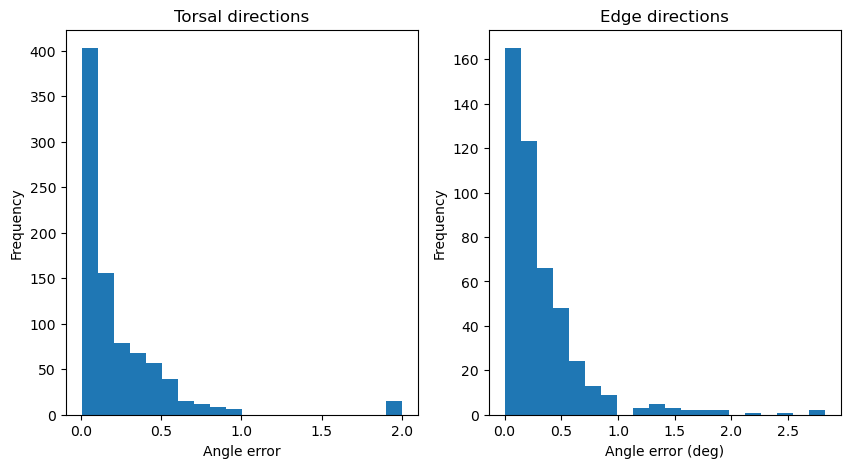

In [10]:
# Show histograms
import matplotlib.pyplot as plt

# Plot two histograms in the same figure but separated
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
# Plot histogram for torsal directions
ax1.hist(errang, bins=20)
ax1.set_xlabel("Angle error")
ax1.set_ylabel("Frequency")
ax1.set_title("Torsal directions")
# Plot histogram for edge directions
ax2.hist(err3, bins=20)
ax2.set_xlabel("Angle error (deg)")
ax2.set_ylabel("Frequency")
ax2.set_title("Edge directions")
plt.show()



### Visualize Torsal directions and errors

In [39]:
# torsal vis settings


# Init polyscope
ps.init()

# Create mesh
mesh = ps.register_surface_mesh("mesh", tv, tf)

# Add cmap mesh
mesh.add_scalar_quantity("errang", errang, defined_on = "faces", enabled=True, cmap="coolwarm")

# color map vertices with edges error
mesh.add_scalar_quantity("err3", err3, defined_on = "vertices", enabled=True, cmap="coolwarm")

# Add torsal directions
mesh.add_vector_quantity(" at1 ", at1, defined_on ='faces', enabled=True, radius=0.001, length=0.005, color=(0.0, 0.0, 0.0))
mesh.add_vector_quantity("-at1", -at1, defined_on ='faces', enabled=True, radius=0.001, length=0.005, color=(0.0, 0.0, 0.0))
mesh.add_vector_quantity(" at2 ", at2, defined_on ='faces', enabled=True, radius=0.001, length=0.005, color=(0.0, 0.0, 0.0))
mesh.add_vector_quantity("-at2", -at2, defined_on ='faces', enabled=True, radius=0.001, length=0.005, color=(0.0, 0.0, 0.0))

mesh.add_vector_quantity("t1 ",  t1, defined_on ='faces', enabled=True, radius=0.001, length=0.005, color=(1.0, 0.0, 0.0))
mesh.add_vector_quantity("-t1", -t1, defined_on ='faces', enabled=True, radius=0.001, length=0.005, color=(1.0, 0.0, 0.0))
mesh.add_vector_quantity("t2 ",  t2, defined_on ='faces', enabled=True, radius=0.001, length=0.005, color=(1.0, 0.0, 0.0))
mesh.add_vector_quantity("-t2", -t2, defined_on ='faces', enabled=True, radius=0.001, length=0.005, color=(1.0, 0.0, 0.0))

# Visualize directions

# mesh.add_vector_quantity("e_i", e_i, defined_on='vertices', enabled=True, radius=0.001, length=2.0, color=(0.0, 0.0, 0.0))
# # mesh.add_vector_quantity("ae_i", edir, defined_on='vertices', enabled=True, radius=0.001, length=2.0, color=(1.0, 1.0, 1.0))

# # Create second mesh of envelope
# mesh2 = ps.register_surface_mesh("mesh2", tv + 3*e_i, tf)

# mesh3 = ps.register_surface_mesh("mesh3", tv + 3.01*edir, tf)


ps.show()

## Save data

In [5]:
def export_torsal_direction(data, tv, tf, e_i):

    # Data 
    k = data

    # Create file for positions
    pos = open(os.path.join( out_path, "torsal_pos_"+str(k)+".dat"), "w")
    # Create file for torsal directions
    tdir = open(os.path.join( out_path, "torsal_dir_"+str(k)+".dat"), "w")
    # Create file to store the ids of the inner faces
    f_if = open(os.path.join( out_path, "inner_faces_"+str(k)+".dat"), "w")

    # Compute torsal directions
    barycenters, t1, t2, cos_tors = torsal_dir_vec(tv, tf, e_i)
    
    # Get inner faces
    t_mesh = Mesh()
    t_mesh.make_mesh(tv, tf)
    inner_faces = t_mesh.inner_faces()

    for ii in range(len(inner_faces)):
        i = inner_faces[ii]
        pos.write(str(barycenters[i][0]) + " " + str(barycenters[i][1]) + " " + str(barycenters[i][2]) + "\n")
        tdir.write(str(t1[i][0]) + " " + str(t1[i][1]) + " " + str(t1[i][2]) + " " + str(t2[i][0]) + " " + str(t2[i][1]) + " " + str(t2[i][2]) + "\n")
        f_if.write(str(i) + "\n")


    pos.close()
    print("Positions file created")
    tdir.close()
    print("Torsal dir files created")
    f_if.close()
    print("Inner faces file created")

def export_toral_data_testing(data, tv, tf, e_i, list_bad_faces):

    # Data
    k = data 

    # Compute torsal directions
    _, t1, t2, _ = torsal_dir_vec(tv, tf, e_i)

    # Create data frame
    df = pd.DataFrame()

    # Create a table with e_i[tf[list_bad_faces]], tv[tf[list_bad_Faces]], t1[list_bad_faces], t2[list_bad_faces]
    df["e_i"] = e_i[tf[list_bad_faces]].tolist()
    df["tv"] = tv[tf[list_bad_faces]].tolist()
    df["t1"] = t1[list_bad_faces].tolist()
    df["t2"] = t2[list_bad_faces].tolist()

    # Export df to csv
    df.to_csv(os.path.join( out_path, "bf_data_"+str(k)+".csv"), index=False)




In [6]:
export_torsal_direction(4, tv, tf, e_i)

Mesh Data Structure: |V| = 1659, |F| = 3171, |E| = 4829
Positions file created
Torsal dir files created
Inner faces file created


In [8]:
export_toral_data_testing(4, tv, tf, e_i, np.array([847,833,806,776,770,767,733,721,688,571]))